In [1]:
## ADMM / Douglas-Rachford algorithm for parameter mapping 
# functions from John Maidens et al DOI: 10.1109/TMI.2018.2844246

import prox_tv as ptv
from math import sqrt
from dataset import read_brainweb_sim_data, read_data_invivo
import os
import numpy as np
import scipy
from scipy import io
import numpy
import matplotlib.pyplot as plt
import glob
import tqdm
import time

In [2]:
def trajectories(kTRANS, kPL, params, Mzscale, Sscale, u): 
    # FUNCTION TRAJECTORIES computes trajectories of the model 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    Ad = numpy.eye(2) + dt*numpy.array([[-kPL-R1P, 0],[kPL, -R1L]]) 
    
    x = numpy.zeros((2, N+1))
    x[0, 0] = P0
    for t in range(N):
        x[:, t+1] = numpy.dot(Ad, Mzscale[:, t]*x[:, t])  + dt*u[t]*numpy.array([kTRANS, 0])
        
    y = x[:, :-1]*Sscale
    return x[:, :-1].T

def traj_1D(kPL, params, Mzscale, Sscale, y1):
    
    # y1 should be the (unscaled) output data from the pyruvate channel
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    x1 = y1/Sscale[0, :]
        
    x2 = numpy.zeros(N) 
    for t in range(N-1):
        x2[t+1] = (-(kPL*numpy.exp((- R1P - kPL)*dt) - kPL*numpy.exp(-R1L*dt))/(R1P - R1L + kPL))*Mzscale[0, t]*x1[t]  +  numpy.exp(-R1L*dt)*Mzscale[1, t]*x2[t]
    return x2*Sscale[1, :]

def theta_step_assumptionless(data, theta, z, u, rho, params, lambda2, Mzscale, Sscale): 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, data):
        return numpy.hstack((data[:, 1] - traj_1D(theta, params, Mzscale, Sscale, data[:, 0]) , sqrt(0.5*rho)*(theta - z + u), sqrt(lambda2)*theta))
    
    theta0  = numpy.array([0.02])
    res = scipy.optimize.leastsq(func, theta0, args=(params, data))

    return res[0]

def theta_step_linear_least_squares(data, theta, z, u, rho, params): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    #sigma = params[5]
    
    # extract relevant vectors 
    P_t      = data[:-1, 0]
    L_t      = data[:-1, 1]
    L_tplus1 = data[1:, 1]
        
    # set up A*theta = b 
    b = L_tplus1 - L_t + dt*R1L*L_t
    A = dt*P_t 
            
    # compute prox operator for 1/2 |A*theta - b|_2^2 
    M = (1/rho)*np.dot(A, A.T) + 1.0
    c = (1/rho)*np.dot(A, b.T) + z - u
    return c/M

def theta_step_maximum_likelihood(data, theta, z, u, rho, params, lambda2, Mzscale, Sscale, u0): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    #sigma = params[5]
    
    def func(theta, params, Y, Mzscale, Sscale, u0):
        return np.hstack(((Y - trajectories(theta[0], theta[1], params, Mzscale, Sscale, u0)).flatten(), sqrt(0.5*rho)*(theta[1]- z + u), sqrt(lambda2)*theta[1]))

    x0  = np.array([0.05, 0.07])
    res = scipy.optimize.leastsq(func, x0, args=(params, data, Mzscale, Sscale, u0))

    return res[0][1]

def z_step(theta, z, u, lambda1, rho):    
    # return ptv.tv1_2d(rho/(2*lambda2 + rho)*(theta + u), lambda1/(lambda2 + 0.5*rho), n_threads=1)
    # return ptv.tv1_2d(theta + u, lambda1/rho, n_threads=1)
    return ptv.tvgen(theta + u, np.array([lambda1/rho, lambda1/rho, lambda1/rho]), [1, 2, 3], np.array([1, 1, 1]))

def u_step(theta, z, u):  
    return u + theta - z


In [3]:
## Prepare and test parallel map function 
import ipyparallel as ipp
#rc = ipp.Cluster(n=4).start_and_connect_sync()
c = ipp.Cluster(n=8, cluster_id="").start_and_connect_sync()
#c = ipp.Client(cluster_id="")
dview = c[:] #.use_cloudpickle()


with dview.sync_imports():
    import numpy as np
    import scipy
    import scipy.optimize





Using existing profile dir: '/home/ssahin/.ipython/profile_default'
Starting 8 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.optimize on engine(s)


In [4]:
def pmap_ndarray(direct_view, f, *args):
    
    shape = args[0].shape
    
    # flatten arguments
    flattened_args = []
    for arg in args:
        assert(arg.shape == shape) # check that all args are the same shape 
        flattened_args.append(arg.flatten())
        
    # apply map function 
    y = direct_view.map_sync(f, *flattened_args)
    
    # reshape result to match shape of args
    return numpy.array(y).reshape(shape)

In [5]:
# load simulated data
data_folder = "/data/ssahin/kpl_dl_sim/brainweb_9_2/sim_data_test/"
xxx = read_brainweb_sim_data(os.path.join(data_folder, "32_4.h5"))
dyn_data_temp = np.transpose(xxx["data"], (1, 2, 0))
dyn_data = np.stack([dyn_data_temp[:,:,:20], dyn_data_temp[:,:,20:]], axis=3)
dyn_data = np.expand_dims(dyn_data, axis=2)

print(dyn_data.shape)
print(xxx['kPL'].shape)
print(xxx['kTRANS'].shape)
kpl_gt = xxx['kPL']

print(np.max(dyn_data[:,:,:,:,:]))

#dyn_data = dyn_data / np.max(dyn_data[:,:,:,:,:])
#print(np.max(dyn_data[:,:,:,:,:]))



(64, 64, 1, 20, 2)
(64, 64)
(64, 64)
0.4605621663727346


In [5]:
# load real data
data_folder = "/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/"
xxx = read_data_invivo(os.path.join(data_folder, "11_3_4.h5"))
dyn_data_temp = np.transpose(xxx["data"], (1, 2, 0))
dyn_data = np.stack([dyn_data_temp[:,:,:20], dyn_data_temp[:,:,20:]], axis=3)
dyn_data = np.expand_dims(dyn_data, axis=2)

print(dyn_data.shape)

print(np.max(dyn_data[:,:,:,:,:]))

(64, 64, 1, 20, 2)
104.31589139898007


In [14]:
filename = 'bbepi_20161026'
matlab_data = io.loadmat(filename + '.mat')
data = numpy.zeros((16, 16, 21, 16, 2))
data[:, :, :, :, 0] = matlab_data['pa']
data[:, :, :, :, 1] = matlab_data['lac']
dyn_data = numpy.transpose(data, (0, 1, 3, 2, 4))
print(dyn_data.shape)
print(np.max(dyn_data[:,:,:,:,:]))

(16, 16, 16, 21, 2)
926.9450073242188


In [6]:
# set up parameters

dt      = 3.0 #2.0
R1L     = 1.0/25.0 #60.0
R1P     = 1.0/30.0 #60.0
P0      = 0.1 #1.2e13 #0.1 #this is Mz0
sigma   = 3000.0
N       = 20 #21
Nz      = 1 #16
params  = np.array([dt, N, R1L, R1P, P0, sigma])

flips = np.stack([np.repeat(20, N), np.repeat(30, N)], axis=0)
#flips = matlab_data['flips']

Sscale = np.sin(np.pi/180*flips)
Mzscale = np.cos(np.pi/180*flips)

#A0 = 100
#t0 = 0
#gamma = 2.14
#beta = 3.47
#t = np.linspace(0, N-1, N)
#u = A0*(t - t0)**gamma*np.exp(-(t-t0)/beta)

In [7]:
def ADMM_parallel_3D(data, lambda1, lambda2, rho, theta_est, z_est, u_est, method, epsilon=None):
    theta = theta_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    z     =     z_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    u     =     u_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    
    # convert data to mappable format
    data_abstract = numpy.zeros(data.shape[0:3], dtype=numpy.ndarray)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                data_abstract[i, j, k] = data[i, j, k, :, :]
    
    # iterate ADMM until convergence, or until we reach max_iter iterations 
    max_iters = 100
    min_iters = 10
    iterations = 0
    if epsilon is None:
        epsilon = 1e-3 #1e-4
    
    # theta_step_vectorized = numpy.vectorize(lambda w, x, y, z: theta_step(w, x, y, z, rho, params))
    u_step_vectorized = numpy.vectorize(u_step)
    
    # broadcast and load required packages, functions, variables 
    dview.push(dict(theta_step_linear_least_squares=theta_step_linear_least_squares, 
                    theta_step_maximum_likelihood=theta_step_maximum_likelihood,
                    theta_step_assumptionless=theta_step_assumptionless,
                    Mzscale=Mzscale,
                    Sscale=Sscale,
                    trajectories=trajectories,
                    traj_1D=traj_1D,
                    sqrt=sqrt,
                    params=params))
    
    while (iterations < min_iters): 
        if (method == "linear-least-squares"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_linear_least_squares(w, x, y, z, rho, params, lambda2), data_abstract, theta, z, u)
        elif (method == "maximum-likelihood"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_maximum_likelihood(w, x, y, z, rho, params, lambda2, Mzscale, Sscale, u0), data_abstract, theta, z, u)
        elif (method == "assumption-less"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_assumptionless(w, x, y, z, rho, params, lambda2, Mzscale, Sscale), data_abstract, theta, z, u)
        else:
            raise ValueError("estimation method '%s' is not defined"%method)
        z     = z_step(theta, z, u, lambda1, rho)
        u     = u_step_vectorized(theta, z, u) # this can be parallelized too if we want, but it's fast
        iterations += 1
    
    while ((iterations < max_iters) and (numpy.linalg.norm(theta - z) > epsilon)):
        #print(numpy.linalg.norm(theta - z))
        if (method == "linear-least-squares"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_linear_least_squares(w, x, y, z, rho, params, lambda2), data_abstract, theta, z, u)
        elif (method == "maximum-likelihood"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_maximum_likelihood(w, x, y, z, rho, params, lambda2, Mzscale, Sscale, u0), data_abstract, theta, z, u)
        elif (method == "assumption-less"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_assumptionless(w, x, y, z, rho, params, lambda2, Mzscale, Sscale), data_abstract, theta, z, u)
        else:
            raise ValueError("estimation method '%s' is not defined"%method)
        z     = z_step(theta, z, u, lambda1, rho)
        u     = u_step_vectorized(theta, z, u) # this can be parallelized too if we want, but it's fast
        iterations += 1

    print("iterations = ", iterations)
    
    return theta

In [8]:
start=time.time()
TV_regularization = 10 #5e04 #10e05
l2_regularization = 500 #1e09 #1e08
rho = 1e3 #1e2
kPL_map = ADMM_parallel_3D(dyn_data, TV_regularization, l2_regularization, rho, 0.0, 0.0, 0.0, "assumption-less")
end = time.time()
print("elapsed time:", end - start)

iterations =  68
elapsed time: 130.4862198829651


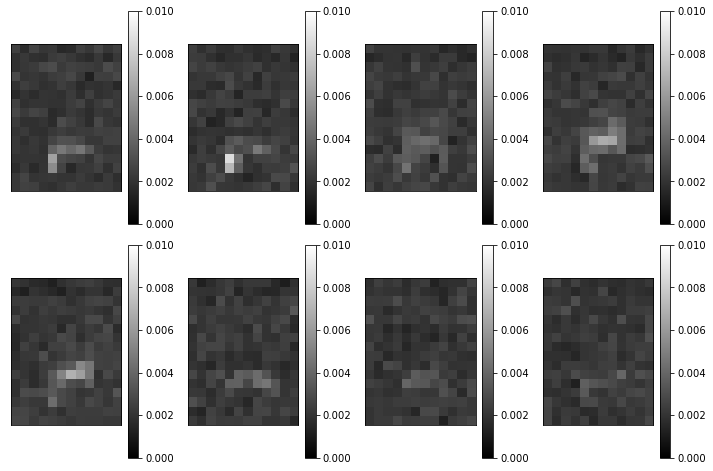

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,13))
for i in range(4, 12):
    plt.subplot(4, 4, i+1)
    plt.imshow(kPL_map[:, 2:14, i], cmap="gray", vmin=-0.000, vmax=0.010, interpolation="nearest")
    # plt.imshow(kPL_map[:, :, i], cmap="gray", vmin=-0.0001, vmax=0.005, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    # plt.title("layer " + str(i+1))
plt.tight_layout()
plt.show()

(64, 64)
0.03684384854280438


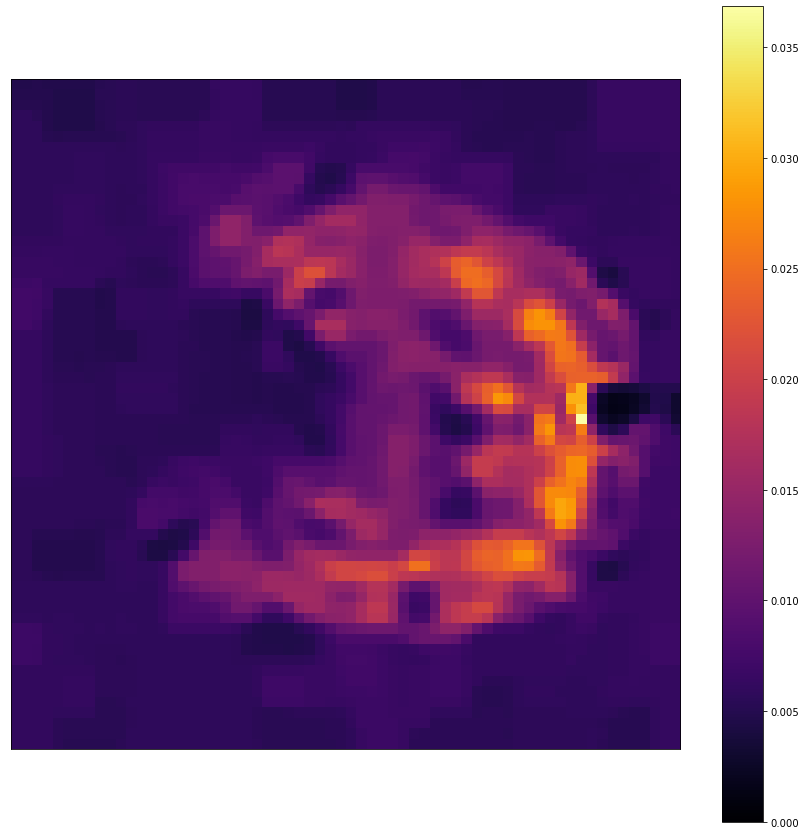

In [21]:
kPL_map = np.squeeze(kPL_map)
print(kPL_map.shape)
print(np.max(kPL_map))

import matplotlib.pyplot as plt
plt.figure(figsize = (15,15))
plt.imshow(kPL_map, cmap="inferno", vmin=-0.000)#, vmax=0.01)
#plt.imshow(kPL_map, cmap="inferno")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

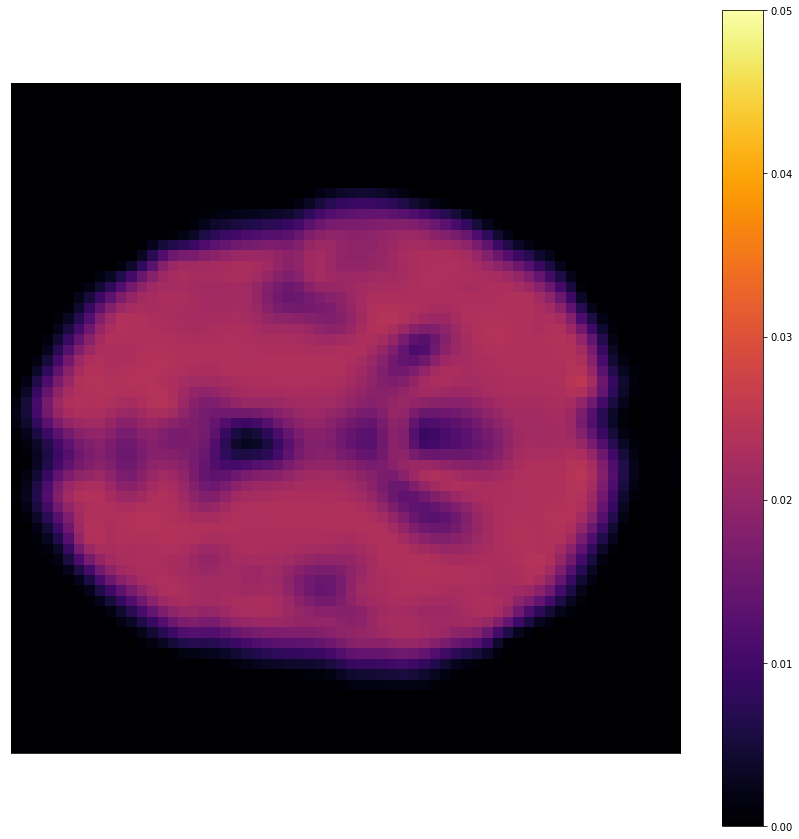

In [27]:
plt.figure(figsize = (15,15))
plt.imshow(kpl_gt, cmap="inferno", vmin=-0.000, vmax=0.05)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

In [15]:
def hyperparameter_selection(data, lambdas, rho):
    
    results = np.zeros((len(lambdas[0]), len(lambdas[1])) + kPL_map.shape)
    
    for j, TV_regularization in enumerate(lambdas[0]):
        for k, l2_regularization in enumerate(lambdas[1]):
            print (j, k)
            # rho = 100*TV_regularization
            kPL = ADMM_parallel_3D(data, TV_regularization, l2_regularization, rho, 0.0, 0.0, 0.0, "assumption-less")
            results[j, k, :, :, :] = kPL
            
    return results

def metrics(results, kPL_true):
    l2_metric = np.zeros(results.shape[:2])
    l1_metric = np.zeros(results.shape[:2])
    for j in range(results.shape[0]):
        for k in range(results.shape[1]):
            l2_metric[j, k] = np.linalg.norm((kPL_true - results[j, k, :, :, :]).flat[:], 2)
            l1_metric[j, k] = np.linalg.norm((kPL_true - results[j, k, :, :, :]).flat[:], 1)
            
    return l2_metric, l1_metric

In [16]:
lambdas = [numpy.round(numpy.linspace(0, 10, 5)), numpy.round(numpy.logspace(0, 4, 5))]
rho = 1e3
print(lambdas)
results = hyperparameter_selection(dyn_data, lambdas, rho)

[array([ 0.,  2.,  5.,  8., 10.]), array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])]
0 0
iterations =  10
0 1
iterations =  10
0 2
iterations =  10
0 3
iterations =  10
0 4
iterations =  10
1 0
iterations =  24
1 1
iterations =  25
1 2
iterations =  25
1 3
iterations =  27
1 4
iterations =  35
2 0
iterations =  43
2 1
iterations =  43
2 2
iterations =  44
2 3
iterations =  46
2 4
iterations =  60
3 0
iterations =  60
3 1
iterations =  60
3 2
iterations =  61
3 3
iterations =  59
3 4
iterations =  74
4 0
iterations =  68
4 1
iterations =  68
4 2
iterations =  68
4 3
iterations =  68
4 4
iterations =  81


In [17]:
#lambdas = [numpy.round(numpy.logspace(0, 2, 3)), numpy.round(numpy.logspace(0, 4, 5))]
lambdas = [numpy.round(numpy.linspace(0, 10, 5)), numpy.round(numpy.logspace(0, 4, 5))]
print(len(lambdas[0]))
print(lambdas)

5
[array([ 0.,  2.,  5.,  8., 10.]), array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])]


In [18]:
print(list(range(len(lambdas[0]))))

[0, 1, 2, 3, 4]


0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


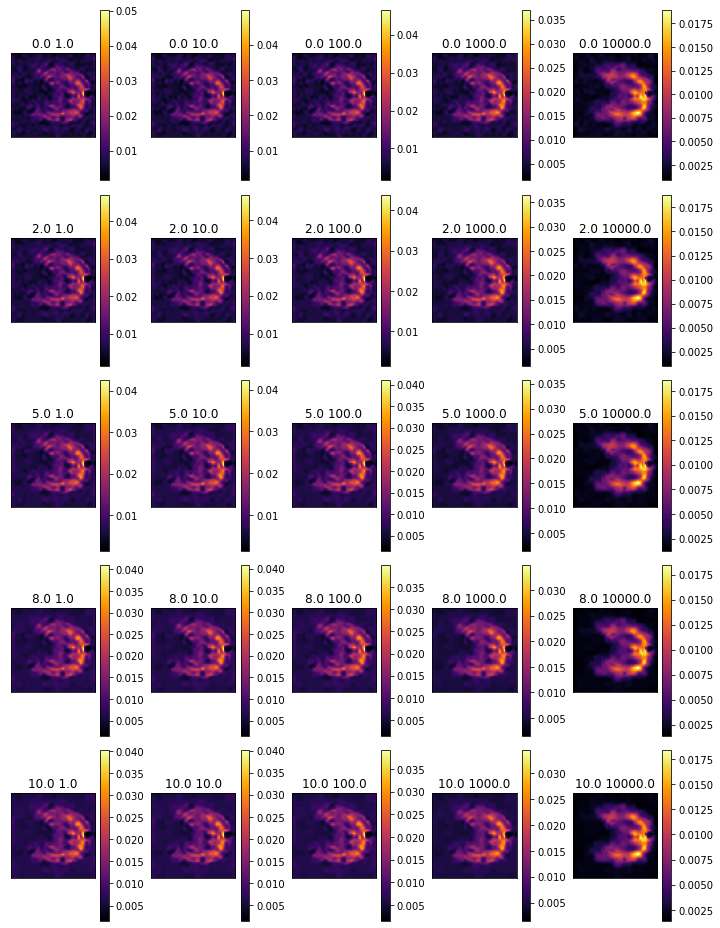

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,13))
i=1
for j in range(len(lambdas[0])):
    for k in range(len(lambdas[1])):
        print(k)
        plt.subplot(len(lambdas[0]), len(lambdas[1]), i)
        plt.imshow(np.squeeze(results[j, k, :, :, :]), cmap="inferno")
        # plt.imshow(kPL_map[:, :, i], cmap="gray", vmin=-0.0001, vmax=0.005, interpolation="nearest")
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.title(str(lambdas[0][j])+" "+ str(lambdas[1][k]))
        i+=1
plt.tight_layout()
plt.show()

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


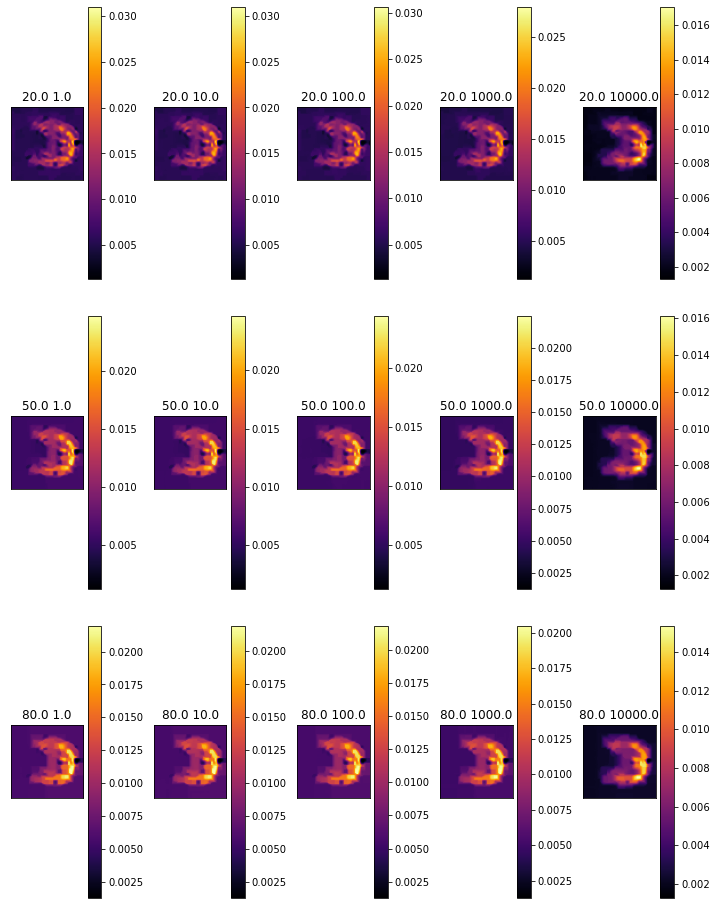

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,13))
i=1
for j in range(len(lambdas[0])):
    for k in range(len(lambdas[1])):
        print(k)
        plt.subplot(len(lambdas[0]), len(lambdas[1]), i)
        plt.imshow(np.squeeze(results[j, k, :, :, :]), cmap="inferno")
        # plt.imshow(kPL_map[:, :, i], cmap="gray", vmin=-0.0001, vmax=0.005, interpolation="nearest")
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.title(str(lambdas[0][j])+" "+ str(lambdas[1][k]))
        i+=1
plt.tight_layout()
plt.show()

In [15]:
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/"
list_val = glob.glob(data_path_test + '/*.h5')
print(list_val)

['/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_6.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_3_5.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_2.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_3_1.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_1.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_3.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_1.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_7.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_5.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_5.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_3_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_8.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/2_10_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/2_10_5.h5', '/data/ssahi

In [17]:
import h5py

data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/"
list_val = glob.glob(data_path_test + '/*.h5')
#list_val = [os.path.join(data_path_test, "11_3_4.h5")]

TV_regularization = 10 #5e04 #10e05
l2_regularization = 500 #1e09 #1e08
rho = 1e3 

for im in tqdm.tqdm(list_val):
    f = h5py.File(im, 'r')
    if "kPL_const" not in f:
        xxx = read_data_invivo(im)
        dyn_data_temp = np.transpose(xxx["data"], (1, 2, 0))
        dyn_data = np.stack([dyn_data_temp[:,:,:20], dyn_data_temp[:,:,20:]], axis=3)
        dyn_data = np.expand_dims(dyn_data, axis=2)


        kPL_map = ADMM_parallel_3D(dyn_data, TV_regularization, l2_regularization, rho, 0.0, 0.0, 0.0, "assumption-less")
        kPL_map = np.squeeze(kPL_map)

        f.close()
        with h5py.File(im, 'a') as hf:
            hf.create_dataset("kPL_const", data=kPL_map)
    else:
        f.close()



  2%|▎         | 1/40 [02:00<1:18:20, 120.51s/it]

iterations =  61


  5%|▌         | 2/40 [05:01<1:38:53, 156.15s/it]

iterations =  92


  8%|▊         | 3/40 [07:33<1:35:11, 154.35s/it]

iterations =  78


 10%|█         | 4/40 [09:50<1:28:19, 147.21s/it]

iterations =  70


 12%|█▎        | 5/40 [12:02<1:22:45, 141.86s/it]

iterations =  67


 15%|█▌        | 6/40 [14:26<1:20:47, 142.58s/it]

iterations =  72


 18%|█▊        | 7/40 [17:11<1:22:31, 150.03s/it]

iterations =  82


 20%|██        | 8/40 [19:23<1:16:52, 144.15s/it]

iterations =  66


 22%|██▎       | 9/40 [21:50<1:15:01, 145.22s/it]

iterations =  74


 25%|██▌       | 10/40 [23:51<1:08:47, 137.59s/it]

iterations =  60


 28%|██▊       | 11/40 [27:03<1:14:31, 154.19s/it]

iterations =  96


 30%|███       | 12/40 [29:37<1:11:55, 154.13s/it]

iterations =  78


100%|██████████| 40/40 [31:50<00:00, 47.75s/it]   

iterations =  68


In [14]:
import h5py
f = h5py.File(list_val[0], 'r')
print(list(f.keys()))
print("kPL_const" not in f)

f.close()

['data_denoise', 'kPL_PK', 'kPL_denoise_PK', 'lac_rsq_PK', 'lac_rsq_denoise_PK', 'mask', 'metImages']
True
